## Imports and Defines

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
teams = pd.read_csv('./src/teams.csv')
players = pd.read_csv('./src/players.csv')
matches = pd.read_csv('./src/matches.csv')

## Players Dataset

Посмотрим на данные в таблице Players

In [3]:
players.head(4)

,player_api_id,player_name,birthday,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,1992-02-29 00:00:00,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,1992-02-29 00:00:00,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,1992-02-29 00:00:00,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,1992-02-29 00:00:00,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [4]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_api_id        183978 non-null  int64  
 1   player_name          183978 non-null  object 
 2   birthday             183978 non-null  object 
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  177109 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

Приведем типы данных

In [5]:
players['date'] = players['date'].astype('datetime64[ns]')
players['birthday'] = players['birthday'].astype('datetime64[ns]')

Создадим колонку с годом

In [6]:
players['player_year'] = players['date'].dt.year

Проверим на некорректные данные (< 0 и > 100)

In [7]:
players_score = players.select_dtypes(include='float64')
players_score_columns = players.select_dtypes(include='float64').columns
((players_score < 0).any().sum(), (players_score > 100).any().sum())

(0, 0)

*Все данные в допустимом диапазоне*

Отделим goalkeepers от других игроков

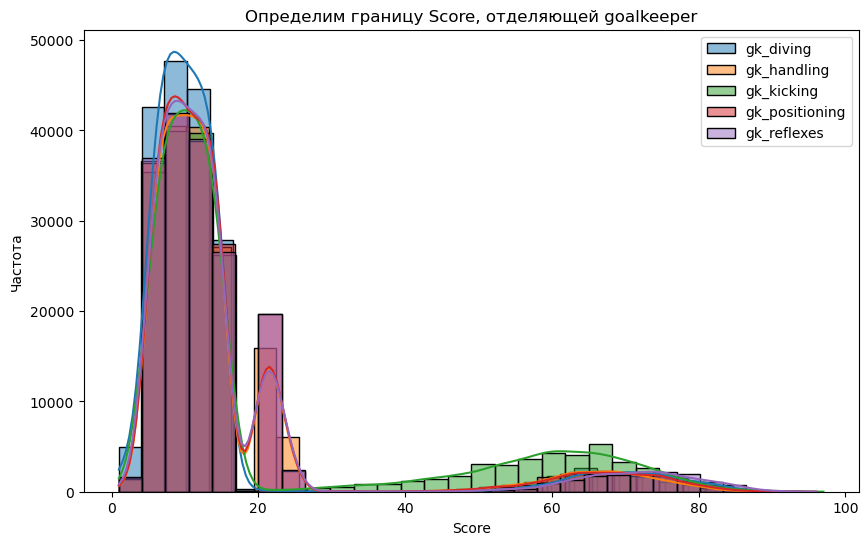

In [8]:
players_gk_columns = [col for col in players_score_columns if col.startswith('gk_')]
players_non_gk_columns = players_score_columns.difference(players_gk_columns)

plt.figure(figsize=(10, 6))

for column in players_gk_columns:
    sns.histplot(players[column], bins=30, kde=True, label=column)

plt.title('Определим границу Score, отделяющей goalkeeper')
plt.xlabel('Score')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [9]:
gk_criteria = 40
players['is_gk'] = (players['gk_positioning'] > gk_criteria) & \
                   (players['gk_reflexes'] > gk_criteria) & \
                   (players['gk_diving'] > gk_criteria) & \
                   (players['gk_handling'] > gk_criteria)

Проверим параметры на пропущенные значения

In [10]:
missing_players_values = players.select_dtypes(include='float').isnull().sum()
missing_players_percentage = (missing_players_values / players.shape[0]) * 100
missing_players_percentage.sort_values(ascending=False)

vision                1.474633
jumping               1.474633
balance               1.474633
volleys               1.474633
sliding_tackle        1.474633
curve                 1.474633
agility               1.474633
overall_rating        0.454402
aggression            0.454402
interceptions         0.454402
positioning           0.454402
marking               0.454402
penalties             0.454402
strength              0.454402
standing_tackle       0.454402
gk_diving             0.454402
gk_handling           0.454402
gk_kicking            0.454402
gk_positioning        0.454402
long_shots            0.454402
shot_power            0.454402
stamina               0.454402
potential             0.454402
reactions             0.454402
sprint_speed          0.454402
acceleration          0.454402
ball_control          0.454402
long_passing          0.454402
free_kick_accuracy    0.454402
dribbling             0.454402
short_passing         0.454402
heading_accuracy      0.454402
finishin

*Пропусков менее 2%*

 Заполним пропуски средним значением (так как нет выбросов).

In [11]:
players_columns_to_fill = missing_players_percentage[missing_players_percentage > 0].index
mean_players_values = players[players_columns_to_fill].mean()
players[players_columns_to_fill] = players[missing_players_percentage[missing_players_percentage > 0].index].fillna(
    mean_players_values)

Вычислим средний Score каждого игрока по атрибутам, соответствующим для игроков разных позиций

In [12]:
def calculate_player_score(row):
    if row['is_gk']:
        return row[players_gk_columns].mean().round(2)
    return row[players_non_gk_columns].mean().round(2)


players['player_score'] = players.apply(calculate_player_score, axis=1)

Так как используемая нами методология расчета player_score проще, чем предлагаемая в данных. То оставим обе. Для улучшения нашего метода можно: разделить на защитников/нападающих/полузащитников, также использовать категориальные переменные.

In [13]:
players = players[['player_api_id', 'player_year', 'overall_rating', 'player_score']]

players.head(2)

,player_api_id,player_year,overall_rating,player_score
0,505942,2016,67.0,57.3
1,505942,2015,67.0,57.3


## Teams Dataset

Посмотрим на данные в Teams Dataset

In [14]:
teams.head(4)

,team_api_id,team_long_name,team_short_name,defenceTeamWidthClass,defenceTeamWidth,defencePressureClass,defencePressure,defenceDefenderLineClass,defenceAggressionClass,defenceAggression,...,chanceCreationPassing,chanceCreationCrossingClass,chanceCreationCrossing,buildUpPlaySpeedClass,buildUpPlaySpeed,buildUpPlayPositioningClass,buildUpPlayPassingClass,buildUpPlayPassing,buildUpPlayDribblingClass,buildUpPlayDribbling
0,9930,FC Aarau,AAR,Normal,45,Medium,50,Cover,Press,55,...,60,Normal,65,Balanced,60,Organised,Mixed,50,Little,NaN
1,9930,FC Aarau,AAR,Normal,54,Medium,47,Cover,Press,44,...,54,Normal,63,Balanced,52,Organised,Mixed,56,Normal,48.0
2,9930,FC Aarau,AAR,Normal,54,Medium,47,Cover,Press,44,...,54,Normal,63,Balanced,47,Organised,Mixed,54,Normal,41.0
3,8485,Aberdeen,ABE,Wide,70,Medium,60,Cover,Double,70,...,70,Lots,70,Fast,70,Organised,Long,70,Little,NaN


In [15]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   team_api_id                     1458 non-null   int64  
 1   team_long_name                  1458 non-null   object 
 2   team_short_name                 1458 non-null   object 
 3   defenceTeamWidthClass           1458 non-null   object 
 4   defenceTeamWidth                1458 non-null   int64  
 5   defencePressureClass            1458 non-null   object 
 6   defencePressure                 1458 non-null   int64  
 7   defenceDefenderLineClass        1458 non-null   object 
 8   defenceAggressionClass          1458 non-null   object 
 9   defenceAggression               1458 non-null   int64  
 10  date                            1458 non-null   object 
 11  chanceCreationShootingClass     1458 non-null   object 
 12  chanceCreationShooting          14

In [16]:
teams['date'] = teams['date'].astype('datetime64[ns]')

Создадим колонку с годом

In [17]:
teams['team_year'] = teams['date'].dt.year

Заменим цифры в начале имен команд

In [18]:
teams['team_long_name'].replace(regex='^\d\.\s', value='', inplace=True)

Проверим на некорректные данные (< 0 и > 100)

In [19]:
teams_score = teams.select_dtypes(include=['float', 'int'])
((teams_score < 0).any(), (teams_score > 100).any())

(team_api_id               False
 defenceTeamWidth          False
 defencePressure           False
 defenceAggression         False
 chanceCreationShooting    False
 chanceCreationPassing     False
 chanceCreationCrossing    False
 buildUpPlaySpeed          False
 buildUpPlayPassing        False
 buildUpPlayDribbling      False
 team_year                 False
 dtype: bool,
 team_api_id                True
 defenceTeamWidth          False
 defencePressure           False
 defenceAggression         False
 chanceCreationShooting    False
 chanceCreationPassing     False
 chanceCreationCrossing    False
 buildUpPlaySpeed          False
 buildUpPlayPassing        False
 buildUpPlayDribbling      False
 team_year                  True
 dtype: bool)

*Некорректных данных - нет.*

In [20]:
missing_teams_values = teams.isnull().sum()
missing_teams_percentage = (missing_teams_values / teams.shape[0]) * 100
missing_teams_percentage.sort_values(ascending=False)

buildUpPlayDribbling              66.460905
team_api_id                        0.000000
team_long_name                     0.000000
buildUpPlayDribblingClass          0.000000
buildUpPlayPassing                 0.000000
buildUpPlayPassingClass            0.000000
buildUpPlayPositioningClass        0.000000
buildUpPlaySpeed                   0.000000
buildUpPlaySpeedClass              0.000000
chanceCreationCrossing             0.000000
chanceCreationCrossingClass        0.000000
chanceCreationPassing              0.000000
chanceCreationPassingClass         0.000000
chanceCreationPositioningClass     0.000000
chanceCreationShooting             0.000000
chanceCreationShootingClass        0.000000
date                               0.000000
defenceAggression                  0.000000
defenceAggressionClass             0.000000
defenceDefenderLineClass           0.000000
defencePressure                    0.000000
defencePressureClass               0.000000
defenceTeamWidth                

Не будем использовать параметр с более 60% пропусков. Удалим его

In [21]:
teams_columns_to_delete = missing_teams_percentage[missing_teams_percentage > 0].index
teams.drop(columns=teams_columns_to_delete, inplace=True)
teams_score_columns = teams.select_dtypes(include=['float', 'int']).columns

Вычислим team_score

In [22]:
teams['team_score'] = teams[
    ['defenceTeamWidth', 'defencePressure', 'defenceAggression', 'chanceCreationShooting',
     'chanceCreationPassing', 'chanceCreationCrossing', 'buildUpPlaySpeed', 'buildUpPlayPassing']].mean(axis=1).round(2)

In [23]:
teams = teams[['team_api_id', 'team_year', 'team_long_name', 'team_short_name', 'team_score']]

In [24]:
teams.head(2)

,team_api_id,team_year,team_long_name,team_short_name,team_score
0,9930,2010,FC Aarau,AAR,55.00
1,9930,2014,FC Aarau,AAR,54.25


## Matches Dataset

Посмотрим на данные Matches

In [25]:
matches.head(4)

,id,country_name,league_name,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.5,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.5,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50


In [26]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 63 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                25979 non-null  int64  
 1   country_name      25979 non-null  object 
 2   league_name       25979 non-null  object 
 3   season            25979 non-null  object 
 4   stage             25979 non-null  int64  
 5   date              25979 non-null  object 
 6   match_api_id      25979 non-null  int64  
 7   home_team_api_id  25979 non-null  int64  
 8   away_team_api_id  25979 non-null  int64  
 9   home_team_goal    25979 non-null  int64  
 10  away_team_goal    25979 non-null  int64  
 11  home_player_1     24755 non-null  float64
 12  home_player_2     24664 non-null  float64
 13  home_player_3     24698 non-null  float64
 14  home_player_4     24656 non-null  float64
 15  home_player_5     24663 non-null  float64
 16  home_player_6     24654 non-null  float6

Приведем типы

In [27]:
matches['date'] = matches['date'].astype('datetime64[ns]')

In [28]:
matches['match_year'] = matches['date'].dt.year

Выясним кол-во пустых значений в столбцах

In [29]:
missing_matches_values = matches.isnull().sum()
missing_matches_percentage = (missing_matches_values / matches.shape[0]) * 100
missing_matches_percentage.sort_values(ascending=False)

PSD            57.011432
PSA            57.011432
PSH            57.011432
BSA            45.490589
BSD            45.490589
                 ...    
date            0.000000
stage           0.000000
season          0.000000
league_name     0.000000
match_year      0.000000
Length: 64, dtype: float64

Удалим строки, которые содержат Null значения в ставках во всей строке

In [30]:
rows_to_drop_h = matches.filter(regex='^\w{2}H$').isnull().all(axis=1)
rows_to_drop_d = matches.filter(regex='^\w{2}D$').isnull().all(axis=1)
rows_to_drop_a = matches.filter(regex='^\w{2}A$').isnull().all(axis=1)

rows_to_drop = rows_to_drop_h | rows_to_drop_d | rows_to_drop_a

matches.drop(matches[rows_to_drop].index, inplace=True)

Посчитаем среднее значение ставок на матч

In [31]:
matches['avg_bet_home'] = matches.filter(regex='^\w{2}H$').mean(axis=1).round(2)
matches['avg_bet_draw'] = matches.filter(regex='^\w{2}D$').mean(axis=1).round(2)
matches['avg_bet_away'] = matches.filter(regex='^\w{2}A$').mean(axis=1).round(2)

In [32]:
matches['avg_bet_home'] = 1/matches['avg_bet_home'].round(2)
matches['avg_bet_draw'] = 1/matches['avg_bet_draw'].round(2)
matches['avg_bet_away'] = 1/matches['avg_bet_away'].round(2)

## Result Dataset

Объединим datasets matches & teams по двум полям, чтобы данные были актуальны на период времени

In [33]:
df = matches.merge(teams, how='left',
                   left_on=['home_team_api_id', 'match_year'],
                   right_on=['team_api_id', 'team_year']) \
    .merge(
    teams, how='left', left_on=['away_team_api_id', 'match_year'], right_on=['team_api_id', 'team_year'],
    suffixes=('_home', '_away')).rename(
    columns={'team_score_home': 'home_team_score', 'team_score_away': 'away_team_score'})

Удалим наблюдения, которые не сможем использовать в обучении модели из-за отсутствия данных.

In [34]:
player_columns = [col for col in matches.columns if 'home_player_' in col or 'away_player_' in col]

df.dropna(subset=['team_long_name_away', 'team_long_name_home'], inplace=True)
df.dropna(subset=player_columns, inplace=True)

Внесем данные из dataset players в Общий dataset и посчитаем средний рейтинг игроков в матче

In [35]:
home_player_columns = [col for col in matches.columns if 'home_player' in col]
away_player_columns = [col for col in matches.columns if 'away_player' in col]

rating_score_dict = players.set_index(['player_api_id', 'player_year'])[['overall_rating', 'player_score']].apply(tuple,
                                                                                                                  axis=1).to_dict()

for column in player_columns:
    df[column + '_rating'] = df.apply(
        lambda row: rating_score_dict.get((row[column], row['match_year']), (None, None))[0], axis=1)
    df[column + '_score'] = df.apply(
        lambda row: rating_score_dict.get((row[column], row['match_year']), (None, None))[1], axis=1)

df['home_players_average_rating'] = df[[col + '_rating' for col in player_columns if 'home' in col]].mean(
    axis=1).round(2)
df['away_players_average_rating'] = df[[col + '_rating' for col in player_columns if 'away' in col]].mean(
    axis=1).round(2)
df['home_players_average_score'] = df[[col + '_score' for col in player_columns if 'home' in col]].mean(axis=1).round(
    2)
df['away_players_average_score'] = df[[col + '_score' for col in player_columns if 'away' in col]].mean(axis=1).round(
    2)

df.drop(columns=[col + '_rating' for col in player_columns] + [col + '_score' for col in player_columns], inplace=True)

Создадим атрибут, показывающий результат матча. 'Draw' - ничья, 'Away Win' - выйгрыш гостевой команды, 'Home Win' - выйгрыш домашней команды

In [36]:
def match_result(home_goals, away_goals):
    if home_goals > away_goals:
        return "Home Win"
    elif home_goals < away_goals:
        return "Away Win"
    else:
        return "Draw"


df['match_result'] = df.apply(lambda row: match_result(row['home_team_goal'], row['away_team_goal']), axis=1)

Выберем нужные данные и сохраним в файл

In [37]:
df[['date', 'season', 'team_long_name_home', 'team_short_name_home', 'team_short_name_away',
    'team_long_name_away',
    'home_team_goal', 'away_team_goal', 'match_result',
    'home_players_average_rating',
    'away_players_average_rating', 'home_players_average_score', 'away_players_average_score', 'away_team_score',
    'home_team_score', 'avg_bet_home', 'avg_bet_draw', 'avg_bet_away']].to_csv('./src/final_dataset.csv', index=False)